## Preparation

In [1]:
!cat  /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) Platinum 8163 CPU @ 2.50GHz
stepping	: 4
microcode	: 0x1
cpu MHz		: 2500.000
cache size	: 33792 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 8
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 22
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq monitor ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa itlb_multihit
bogomips	: 5000.00
clflush size

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5931af09-0c87-acb8-fa72-94b3a62c5179)


In [3]:
%%capture
!pip install tensorly
!pip install --upgrade torch torchvision

In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
print(torch.__version__)
torch.manual_seed(0)

from trainer import train, test
from tucker_layer import TuckerLayer

1.10.1+cu102


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
train_data = torchvision.datasets.FashionMNIST(root='./downloads/4717', train=True, download=True, transform=transform)
train_val_split = (int(len(train_data) * 0.8), len(train_data) - int(len(train_data) * 0.8))
train_data, val_data = torch.utils.data.random_split(train_data, train_val_split)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=False, num_workers=0)

test_data = torchvision.datasets.FashionMNIST(root='./downloads/4717', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=0)

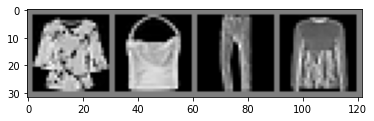

tensor(6) tensor(8) tensor(1) tensor(2)


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

## ALexNet

In [8]:
class AlexNet(nn.Module):   
    def __init__(self, num=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True), 
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),   
            nn.MaxPool2d( kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32*12*12,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num),
         
        )
    
    def forward(self, x):

        x = self.features(x)
        x = x.view(-1,32*12*12)
        x = self.classifier(x)
        return x

In [9]:
AlexNet_model = AlexNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
AlexNet_model.to(device)
def loss_func1(model, output, labels):
    return nn.CrossEntropyLoss()(output, labels)
optimizer1 = optim.SGD(
    [
        {"params": AlexNet_model.features.parameters(), "lr": 0.0001, "momentum": 0.9},
        {"params": AlexNet_model.classifier.parameters(), "lr": 0.001, "momentum": 0.9},
    ],
    lr=0.0001,
)
scheduler1 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer1, T_0=1, T_mult=2, verbose=False)

cuda:0


In [10]:
train(model=AlexNet_model,
      train_loader=trainloader,
      val_loader=valloader,
      epoch_num=63,
      optimizer=optimizer1,
      scheduler=scheduler1,
      scheduler_step='batch',
      loss_func=loss_func1,
      path='alexnet')

## AlexNet Tucker Compression without orthogonal

In [11]:
AlexTucker_model = AlexNet()
AlexTucker_model.load_state_dict(torch.load('alexnet_best.pth'))

<All keys matched successfully>

In [12]:
for i in [2, 5, 7, 9]:
    AlexTucker_model.features[i] = TuckerLayer.from_Conv2D(AlexTucker_model.features[i], method='HOSVD')

Tucker Decompose with rank (3, 2)
/home/pai/lib/python3.6/site-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'
Tucker Decompose with rank (6, 5)
Tucker Decompose with rank (7, 9)
Tucker Decompose with rank (7, 7)


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
AlexTucker_model.to(device)
optimizer2 = optim.SGD(
    [
        {"params": AlexTucker_model.features.parameters(), "lr": 0.0005, "momentum": 0.9},
        {"params": AlexTucker_model.classifier.parameters(), "lr": 0.0001, "momentum": 0.9},
    ],
    lr=0.0001,
)
scheduler2 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer2, T_0=1, T_mult=2, verbose=False)

cuda:0


In [14]:
before_accu = test(AlexTucker_model, valloader)
print('Acuracy: {:.3f}'.format(before_accu * 100))

Acuracy: 66.275


In [15]:
train(model=AlexTucker_model,
      train_loader=trainloader,
      val_loader=valloader,
      epoch_num=63,
      optimizer=optimizer2,
      scheduler=scheduler2,
      scheduler_step='batch',
      loss_func=loss_func1,
      path='alexnet_tucker')

[43,  2000] loss: 0.050 Time: 14.619 14.620
[43,  4000] loss: 0.049 Time: 29.654 29.654
[43,  6000] loss: 0.048 Time: 44.624 44.625
[43,  8000] loss: 0.052 Time: 59.603 59.603
[43, 10000] loss: 0.048 Time: 74.438 74.438
[43, 12000] loss: 0.050 Time: 89.539 89.539
Accuracy: 92.483
[44,  2000] loss: 0.046 Time: 14.099 112.657
[44,  4000] loss: 0.052 Time: 27.409 125.967
[44,  6000] loss: 0.050 Time: 42.190 140.748
[44,  8000] loss: 0.046 Time: 57.306 155.864
[44, 10000] loss: 0.051 Time: 72.615 171.173
[44, 12000] loss: 0.048 Time: 87.671 186.230
Accuracy: 92.442
[45,  2000] loss: 0.044 Time: 14.750 209.887
[45,  4000] loss: 0.046 Time: 29.868 225.005
[45,  6000] loss: 0.045 Time: 45.194 240.330
[45,  8000] loss: 0.044 Time: 59.877 255.014
[45, 10000] loss: 0.048 Time: 74.649 269.786
[45, 12000] loss: 0.045 Time: 89.040 284.176
Accuracy: 92.525
[46,  2000] loss: 0.044 Time: 14.701 306.911
[46,  4000] loss: 0.038 Time: 29.839 322.049
[46,  6000] loss: 0.041 Time: 45.059 337.269
[46,  8000

In [16]:
del(AlexTucker_model)

In [19]:
test_model_from_path('alexnet')
test_model_from_path('alexnet_tucker')
print(before_accu)

11696202
148544
93.090
5.705698490142822
11553214
5556
92.810
6.280418395996094
0.66275


## AlexNet Tucker Compression with orthogonal

In [ ]:
AlexTucker_model = AlexNet()
AlexTucker_model.load_state_dict(torch.load('alexnet_best.pth'))

In [ ]:
for i in [2, 5, 7, 9]:
    AlexTucker_model.features[i] = TuckerLayer.from_Conv2D(AlexTucker_model.features[i], method='HOSVD')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
AlexTucker_model.to(device)
def loss_func2(model, output, labels):
    loss1 = nn.CrossEntropyLoss()(output, labels)
    loss2 = 0.0
    for i in [2, 5, 7, 9]:
        loss2 += model.features[i].orthogonal_error()
    return loss1 + 0.01 * loss2
optimizer3 = optim.SGD(
    [
        {"params": AlexTucker_model.features.parameters(), "lr": 0.0005, "momentum": 0.9},
        {"params": AlexTucker_model.classifier.parameters(), "lr": 0.0001, "momentum": 0.9},
    ],
    lr=0.0001,
)
scheduler3 = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer3, T_0=1, T_mult=2, verbose=False)

In [ ]:
train(model=AlexTucker_model,
      train_loader=trainloader,
      val_loader=valloader,
      epoch_num=31,
      optimizer=optimizer3,
      scheduler=scheduler3,
      scheduler_step='batch',
      loss_func=loss_func2,
      path='alexnet_tucker2')

In [ ]:
del(AlexTucker_model)

In [18]:
def count_parameters(paras):
    return sum(p.numel() for p in paras if p.requires_grad)
def test_model_from_path(model_path):
    model = torch.jit.load(model_path + '.pt')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    start_time = time.time()
    print(count_parameters(model.parameters()))
    print(count_parameters(model.features.parameters()))
    print('{:.3f}'.format(test(model, testloader) * 100))
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    print(time.time() - start_time)

In [ ]:
test_model_from_path('alexnet')
test_model_from_path('alexnet_tucker')
test_model_from_path('alexnet_tucker2')
print(before_accu)